Team Members: <br>
1) Neha Anna John: na25753<br>
2) Rawini Dias: rwd635<br>
3) Christopher Henson: cgh966<br>
4) Sadhana Koneni: sk44735<br>
5) Satya Pachigolla: sp46958<br>

## Task A

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import pickle
import pandas as pd
import numpy as np

post_df = pickle.load( open( "labels_instagram_posts_13Nov.p", "rb" ) )

In [6]:
post_df.shape

(472, 6)

In [7]:
post_df.head()

,Unnamed: 0,post_url,num_likes,num_comments,caption,labels
0,0,https://scontent-sea1-1.cdninstagram.com/vp/8e...,455787,1234,Photo by Jimmy Chin @jimmychin | Half Dome aft...,"[Mountainous landforms, Mountain, White, Black..."
1,1,https://scontent-sea1-1.cdninstagram.com/vp/51...,246999,941,Photos by Ian Teh @iantehphotography | I’m on ...,"[Motor vehicle, Vehicle, Mode of transport, Au..."
2,2,https://scontent-sea1-1.cdninstagram.com/vp/21...,610340,3481,Photo by Thomas Peschak @thomaspeschak | The m...,"[Green sea turtle, Turtle, Sea turtle, Reptile..."
3,3,https://scontent-sea1-1.cdninstagram.com/vp/78...,160973,492,Photo by Katie Orlinsky @katieorlinsky | Olga ...,"[Temple, Cuisine]"
4,4,https://scontent-sea1-1.cdninstagram.com/vp/03...,185601,730,"Photo by Tasneem Alsultan @TasneemAlsultan | ""...","[Tree, Palm tree, Arecales, Woody plant, Plant..."


In [0]:
post_df['num_likes'] = post_df.num_likes.map(lambda x: float(x)/post_df.num_likes.max())
post_df['num_comments'] = post_df.num_comments.map(lambda x: float(x)/post_df.num_comments.max())

In [0]:
post_df['engagement'] = 0.4*post_df['num_likes']+0.6*post_df['num_comments']

In [0]:
post_df['e_lev'] = post_df.engagement.map(lambda x: 1 if x > post_df.engagement.median() else 0)

In [0]:
post_df['caption'] = post_df.caption.map(lambda x: x.lower())

In [0]:
post_df['labels'] = post_df.labels.map(lambda x: [i.lower() for i in x])

# Task B

Conclusion: Our best accuracy (81%) was given by regression on just the TF-IDF scores for the captions. Using both the labels and captions (with TF-IDF) actually reduced our accuracy. We can conclude that this additional information introduced either collinearity or noise that reduced accuracy. 

# Labels

In [0]:
reg_df = post_df[['labels','e_lev']]

In [14]:
reg_df.head()

,labels,e_lev
0,"[mountainous landforms, mountain, white, black...",1
1,"[motor vehicle, vehicle, mode of transport, au...",0
2,"[green sea turtle, turtle, sea turtle, reptile...",1
3,"[temple, cuisine]",0
4,"[tree, palm tree, arecales, woody plant, plant...",0


In [0]:
labels = list(set([i for l in post_df.labels for i in l]))

In [0]:
for l in labels:
  reg_df[l] = reg_df.labels.map(lambda x: 1 if l in x else 0) 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

X = reg_df.drop(columns=['e_lev','labels'])
Y = reg_df['e_lev']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20, random_state=11)
log_reg = LogisticRegression(random_state = 20,class_weight = 'balanced')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy_score(y_test, y_pred)

0.7157894736842105

# Labels tf-idf

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')


import scipy
from scipy import sparse

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
reg_tfidf = post_df[['labels','e_lev']]

reg_tfidf['labels_join'] = reg_tfidf.labels.map(lambda x: ' '.join(x))

In [0]:
X = reg_tfidf.drop(columns=['e_lev'])
Y = reg_tfidf['e_lev']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20, random_state=11)
log_reg = LogisticRegression(random_state = 20,class_weight = 'balanced')


In [0]:
tf_idf = TfidfVectorizer(max_features=300, analyzer='word', stop_words='english', dtype=np.float32, ngram_range=(1,3))

tr = tf_idf.fit_transform(X_train['labels_join'])
ts = tf_idf.transform(X_test['labels_join'])

In [22]:
log_reg.fit(tr, y_train)
y_pred = log_reg.predict(ts)
accuracy_score(y_test, y_pred)

0.7263157894736842

# Captions tf-idf

In [0]:
reg_cap_tfidf = post_df[['caption','e_lev']]

X = reg_cap_tfidf.drop(columns=['e_lev'])
Y = reg_cap_tfidf['e_lev']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20, random_state=11)
log_reg = LogisticRegression(random_state = 20,class_weight = 'balanced')

In [0]:
tf_idf = TfidfVectorizer(max_features=3000, analyzer='word', stop_words= 'english', ngram_range=(1,3), dtype=np.float32)

tr = tf_idf.fit_transform(X_train['caption'])
ts = tf_idf.transform(X_test['caption'])

In [25]:
log_reg.fit(tr, y_train)
y_pred = log_reg.predict(ts)
accuracy_score(y_test, y_pred)

0.7684210526315789

# Captions lemmatize tf-idf

In [0]:
import spacy

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

In [0]:
reg_cap_tfidf = post_df[['caption','e_lev']]

X = reg_cap_tfidf.drop(columns=['e_lev'])
Y = reg_cap_tfidf['e_lev']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20, random_state=11)
log_reg = LogisticRegression(random_state = 20,class_weight = 'balanced')

In [0]:
lemmatizer = WordNetLemmatizer()

# Tokenize and Lemmatize list of words and join
lemmatized_tr = X_train.caption.map(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
lemmatized_ts = X_test.caption.map(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [0]:
tf_idf = TfidfVectorizer(max_features=3000, analyzer='word', stop_words= 'english', ngram_range=(1,3), dtype=np.float32)

tr = tf_idf.fit_transform(lemmatized_tr)
ts = tf_idf.transform(lemmatized_ts)

In [30]:
log_reg.fit(tr, y_train)
y_pred = log_reg.predict(ts)
accuracy_score(y_test, y_pred)

0.8105263157894737

# Captions and Labels tf-idf

In [0]:
reg_all_tfidf = post_df[['labels', 'caption', 'e_lev']]

reg_all_tfidf['labels_join'] = reg_all_tfidf.labels.map(lambda x: ' '.join(x))


X = reg_all_tfidf.drop(columns=['e_lev'])
Y = reg_all_tfidf['e_lev']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20, random_state=11)
log_reg = LogisticRegression(random_state = 20,class_weight = 'balanced')

In [0]:
lemmatizer = WordNetLemmatizer()

# Tokenize and Lemmatize list of words and join
lemmatized_tr = X_train.caption.map(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
lemmatized_ts = X_test.caption.map(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [0]:
tf_idf = TfidfVectorizer(max_features=3000, analyzer='word', stop_words= 'english', dtype=np.float32,  ngram_range=(1,3))

tr = tf_idf.fit_transform(lemmatized_tr)
ts = tf_idf.transform(lemmatized_ts)

In [0]:
tf_idf_l = TfidfVectorizer(max_features=300, analyzer='word', stop_words= 'english', dtype=np.float32, ngram_range=(1,3))

tr_l = tf_idf_l.fit_transform(X_train['labels_join']) #lemmatized_tr_l)#
ts_l = tf_idf_l.transform(X_test['labels_join']) #lemmatized_ts_l)

In [0]:
train = sparse.hstack([tr,tr_l])
test = sparse.hstack([ts,ts_l])

In [36]:
log_reg.fit(train, y_train)
y_pred = log_reg.predict(test)
accuracy_score(y_test, y_pred)

0.7684210526315789

# Task C

## Topic Modeling

In [37]:
post_df.head(5)

,Unnamed: 0,post_url,num_likes,num_comments,caption,labels,engagement,e_lev
0,0,https://scontent-sea1-1.cdninstagram.com/vp/8e...,0.281916,0.094770,photo by jimmy chin @jimmychin | half dome aft...,"[mountainous landforms, mountain, white, black...",0.169628,1
1,1,https://scontent-sea1-1.cdninstagram.com/vp/51...,0.152775,0.072268,photos by ian teh @iantehphotography | i’m on ...,"[motor vehicle, vehicle, mode of transport, au...",0.104471,0
2,2,https://scontent-sea1-1.cdninstagram.com/vp/21...,0.377510,0.267337,photo by thomas peschak @thomaspeschak | the m...,"[green sea turtle, turtle, sea turtle, reptile...",0.311407,1
3,3,https://scontent-sea1-1.cdninstagram.com/vp/78...,0.099566,0.037785,photo by katie orlinsky @katieorlinsky | olga ...,"[temple, cuisine]",0.062497,0
4,4,https://scontent-sea1-1.cdninstagram.com/vp/03...,0.114799,0.056063,"photo by tasneem alsultan @tasneemalsultan | ""...","[tree, palm tree, arecales, woody plant, plant...",0.079557,0


In [0]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary


In [0]:
dictionary = gensim.corpora.Dictionary(post_df.labels)

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

In [0]:
bow_corpus = [dictionary.doc2bow(label) for label in post_df.labels]

In [0]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=2, workers=2, chunksize=100, random_state=1000)

In [0]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [131]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.040*"adaptation" + 0.032*"photography" + 0.023*"people" + '
        '0.020*"human" + 0.019*"smile" + 0.015*"event" + 0.014*"tree" + '
        '0.013*"crowd" + 0.011*"grassland" + 0.011*"community"'),
    (   1,
        '0.023*"wildlife" + 0.018*"vertebrate" + 0.017*"sky" + 0.015*"water" + '
        '0.013*"plant" + 0.013*"grass" + 0.012*"terrestrial animal" + '
        '0.011*"tree" + 0.011*"organism" + 0.011*"green"'),
    (   2,
        '0.045*"sky" + 0.026*"water" + 0.022*"cloud" + 0.021*"tree" + '
        '0.017*"natural landscape" + 0.016*"ocean" + 0.016*"nature" + '
        '0.016*"sea" + 0.014*"wildlife" + 0.014*"blue"'),
    (   3,
        '0.029*"sky" + 0.018*"architecture" + 0.014*"photography" + '
        '0.014*"geological phenomenon" + 0.013*"mountain" + 0.011*"adaptation" '
        '+ 0.011*"building" + 0.011*"night" + 0.011*"mountain range" + '
        '0.010*"recreation"'),
    (   4,
        '0.022*"photography" + 0.020*"rock" + 0.019*"landscape" 

# Topic Descriptions
Topic 0: Community <br>
Topic 1: Wildlife <br>
Topic 2: Nature <br>
Topic 3: Photography <br>
Topic 4: Landscape <br>
Topic 5: Marine <br>

In [0]:
post_topics = post_df.copy(deep=True)

post_topics['topic_0'] = 0.0
post_topics['topic_1'] = 0.0
post_topics['topic_2'] = 0.0
post_topics['topic_3'] = 0.0
post_topics['topic_4'] = 0.0
post_topics['topic_5'] = 0.0

In [0]:
for index, row in post_topics.iterrows():
    bow = dictionary.doc2bow(row['labels'])
    t = lda_model.get_document_topics(bow)
    post_topics['topic_0'].loc[index] = t[0][1]
    post_topics['topic_1'].loc[index] = t[1][1]
    post_topics['topic_2'].loc[index] = t[2][1]
    post_topics['topic_3'].loc[index] = t[3][1]
    post_topics['topic_4'].loc[index] = t[4][1]
    post_topics['topic_5'].loc[index] = t[5][1]

In [134]:
post_topics.head(3)

,Unnamed: 0,post_url,num_likes,num_comments,caption,labels,engagement,e_lev,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0,https://scontent-sea1-1.cdninstagram.com/vp/8e...,0.281916,0.094770,photo by jimmy chin @jimmychin | half dome aft...,"[mountainous landforms, mountain, white, black...",0.169628,1,0.015168,0.015195,0.923985,0.015293,0.015163,0.015196
1,1,https://scontent-sea1-1.cdninstagram.com/vp/51...,0.152775,0.072268,photos by ian teh @iantehphotography | i’m on ...,"[motor vehicle, vehicle, mode of transport, au...",0.104471,0,0.016722,0.016740,0.016880,0.016830,0.916153,0.016676
2,2,https://scontent-sea1-1.cdninstagram.com/vp/21...,0.377510,0.267337,photo by thomas peschak @thomaspeschak | the m...,"[green sea turtle, turtle, sea turtle, reptile...",0.311407,1,0.015282,0.015198,0.015187,0.015213,0.015205,0.923914


In [0]:
labels = list(set([i for l in post_df.labels for i in l]))

word_loadings = pd.DataFrame(labels, columns=['word'])
word_loadings['topic_0'] = 0.0
word_loadings['topic_1'] = 0.0
word_loadings['topic_2'] = 0.0
word_loadings['topic_3'] = 0.0
word_loadings['topic_4'] = 0.0
word_loadings['topic_5'] = 0.0

In [0]:
for index, row in word_loadings.iterrows():
  try:
    w = lda_model.get_term_topics(row['word'], minimum_probability=0.000001)
    word_loadings['topic_0'].loc[index]  = w[0][1]
    word_loadings['topic_1'].loc[index]  = w[1][1]
    word_loadings['topic_2'].loc[index]  = w[2][1]
    word_loadings['topic_3'].loc[index]  = w[3][1]
    word_loadings['topic_4'].loc[index]  = w[4][1]
    word_loadings['topic_5'].loc[index]  = w[5][1]
  except:
    pass

In [139]:
word_loadings.head(5)

,word,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,visual arts,0.000003,0.000003,0.000001,0.000003,0.000752,0.003611
1,squeezebox,0.000003,0.000003,0.000001,0.000548,0.000002,0.000002
2,free solo climbing,0.000003,0.000492,0.000001,0.000003,0.000002,0.000002
3,holy places,0.000003,0.000003,0.000001,0.000003,0.001463,0.000002
4,arctic,0.004423,0.001452,0.002863,0.000003,0.000002,0.000002


# Quartiles

In [0]:
post_topics['quartile'] = pd.qcut(post_topics['engagement'], 4, labels=False)

In [141]:
post_topics.head(2)

,Unnamed: 0,post_url,num_likes,num_comments,caption,labels,engagement,e_lev,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,quartile
0,0,https://scontent-sea1-1.cdninstagram.com/vp/8e...,0.281916,0.094770,photo by jimmy chin @jimmychin | half dome aft...,"[mountainous landforms, mountain, white, black...",0.169628,1,0.015168,0.015195,0.923985,0.015293,0.015163,0.015196,2
1,1,https://scontent-sea1-1.cdninstagram.com/vp/51...,0.152775,0.072268,photos by ian teh @iantehphotography | i’m on ...,"[motor vehicle, vehicle, mode of transport, au...",0.104471,0,0.016722,0.016740,0.016880,0.016830,0.916153,0.016676,1


In [142]:
post_topics.groupby('quartile')[['topic_0','topic_1','topic_2','topic_3','topic_4','topic_5']].mean()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
quartile,,,,,,
0,0.210167,0.104536,0.234577,0.165356,0.177029,0.108335
1,0.173747,0.115998,0.336027,0.101710,0.138241,0.134278
2,0.107306,0.141037,0.381435,0.094611,0.123409,0.152202
3,0.099517,0.155606,0.365873,0.123437,0.123828,0.131738


## Writing to CSV

In [0]:
post_topics.to_csv('image_topic_weights.csv', index=False)
word_loadings.to_csv('word_loadings.csv', index=False)

# Task D

# Conclusion and Recommendations

Images of 'Nature' are associated with the highest engagement scores. The second hgihest engagement scores are associated with 'Wildlife' images. The images belonging to topic 'Community' have the lowest engagement scores. 

Natgeo can increase engagement by posting more pictures of nature and wildlife. While we havent analyzed interaction between topics, it could be that images related to people tend to decrease engagement.

Topic 0: Community <br>
Topic 1: Wildlife <br>
Topic 2: Nature <br>
Topic 3: Photography <br>
Topic 4: Landscape <br>
Topic 5: Marine <br>

# Visualization

In [143]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=5b2c4e47b95e048edec2fbeea6f079f57a388012d1edbb8ac8ade1b04b07b41f
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [144]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.029511 -0.137580       1        1  34.858616
0      0.095885  0.113624       2        1  13.787217
4     -0.009590 -0.011829       3        1  13.618925
1      0.085359 -0.000934       4        1  12.912285
5     -0.136650  0.062376       5        1  12.708349
3     -0.064515 -0.025657       6        1  12.114611, topic_info=    Category       Freq            Term      Total  loglift  logprob
19   Default  46.000000      adaptation  46.000000  30.0000  30.0000
251  Default  27.000000            fish  27.000000  29.0000  29.0000
28   Default  24.000000      underwater  24.000000  28.0000  28.0000
44   Default  21.000000          people  21.000000  27.0000  27.0000
21   Default  22.000000  marine biology  22.000000  26.0000  26.0000
..       ...        ...             ...        ...      ...      ...
112   Topic6   3.148904            beak  12.602669   0.7239  -5.0884
69    Topic6   3.855470           water  62.989471  -0.6827  -4.8859
41    Topic6   3.360464           human  22.662970   0.2021  -5.0233
319   Topic6   3.150610           horse  12.743585   0.7133  -5.0878
70    Topic6   3.214096      wilderness  22.411255   0.1687  -5.0679

[378 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
19        1  0.128188  adaptation
19        2  0.491386  adaptation
19        3  0.085458  adaptation
19        4  0.106823  adaptation
19        5  0.064094  adaptation
...     ...       ...         ...
491       1  0.380281       world
491       3  0.570422       world
926       5  0.769629     wrasses
281       2  0.851551     wrinkle
336       2  0.713785       youth

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 6, 4])

# Conclusion from the plot

From the plot below, we observe that the topics are well separated and it confirms that our choice of the number of topics was optimal. 

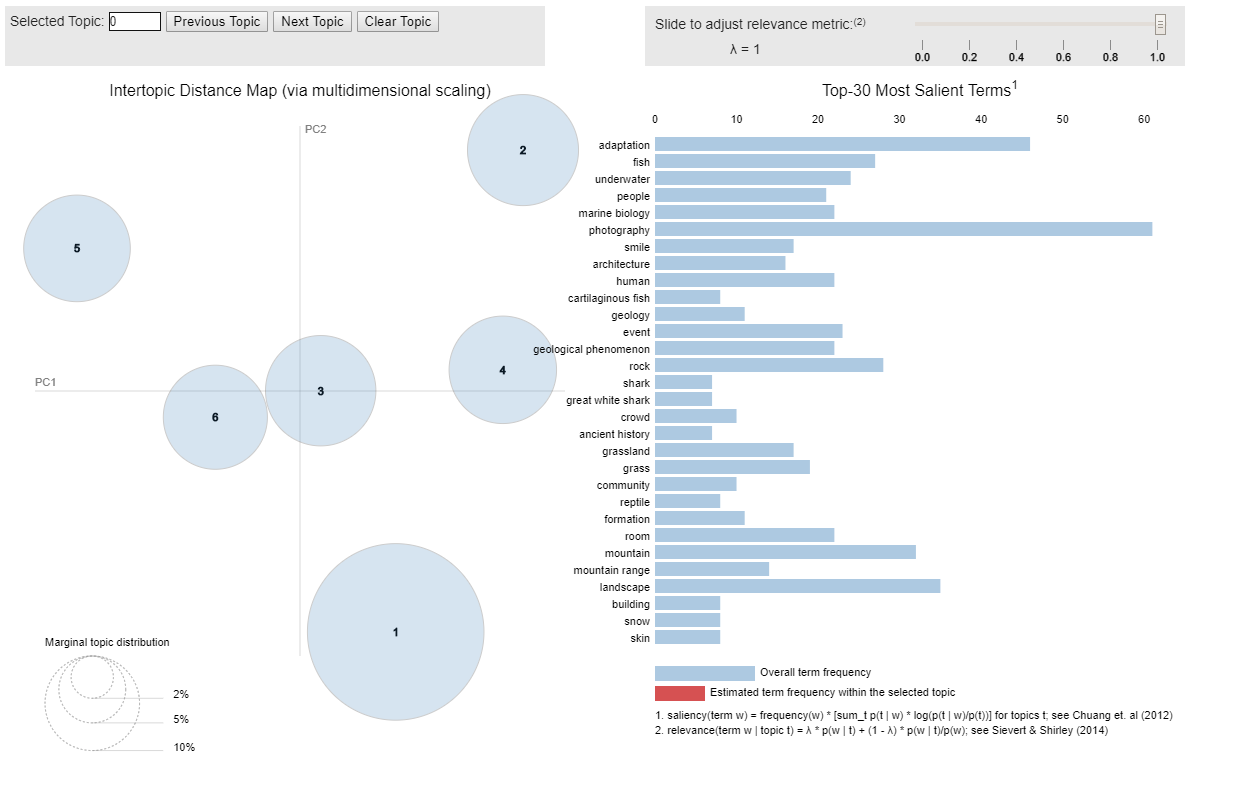

In [1]:
# output from the pyLDAvis code
from IPython.display import Image

Image('topics_vis.PNG')